In [1]:
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
import pandas as pd

# adding '../ocean/src/model/' to sys.path
sys.path.append(os.path.abspath('../../ocean/src/model/'))

from model import SuperResolution

In [2]:
INPUT_DIM_X = 272 # input image is going to be resized to this size
INPUT_DIM_Y = 160
BATCH_SIZE = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_dataset(psi):
    # loading the dataset
    data_path = f'../data/dataset/{psi}/test_set' # setting path
    # sequence of transformations to be done
    transform = transforms.Compose([transforms.Resize((INPUT_DIM_X, INPUT_DIM_Y)),   # sequence of transformations to be done
                                    transforms.Grayscale(num_output_channels=1), # on each image (resize, greyscale,
                                    transforms.ToTensor()])                      # convert to tensor)

    dataset = datasets.ImageFolder(root=data_path, transform=transform) # read data from folder
    return dataset

def load_model(DOWNGRADE_FACTOR, PSI):
    # Initialize some constants
    # if starting epoch is not 0, load from last trained model
    model = SuperResolution().to(DEVICE)
    model.load_state_dict(torch.load(f'../models/model_{PSI}_x{DOWNGRADE_FACTOR}_200'))
    return model

def mse(img1, img2):
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img1.shape[1])
    return err

def evaluate_prediction(x, DOWNGRADE_FACTOR):
    lr_x = F.interpolate(x.unsqueeze(0), size=(INPUT_DIM_X//DOWNGRADE_FACTOR, INPUT_DIM_Y//DOWNGRADE_FACTOR), mode='bilinear', align_corners=False)
    lr_x = F.interpolate(lr_x, size=(INPUT_DIM_X, INPUT_DIM_Y), mode='bilinear', align_corners=False)

    y = model(lr_x[0].to(DEVICE)).cpu()[0].detach().numpy()

    mse_lr_hr = mse(lr_x.numpy()[0][0], x.numpy()[0])
    mse_out_hr = mse(y, x.numpy()[0])
    ssim_lr_hr = ssim(lr_x.numpy()[0][0], x.numpy()[0], data_range=1)
    ssim_out_hr = ssim(y, x.numpy()[0], data_range=1)
    return [mse_lr_hr, mse_out_hr, ssim_lr_hr, ssim_out_hr]

# iterate over every image in test_set
def metrics_dataframe():
    metrics_df = []
    for psi in ['psi1', 'psi2']:
        dataset = load_dataset(psi)
        for downgrade_factor in [4, 8, 16]:
            metrics = []
            model = load_model(downgrade_factor, psi)
            for i in range(len(dataset)):
                x = dataset[i][0]
                evaluation = evaluate_prediction(x, downgrade_factor)
                metrics.append(evaluation)
            print(psi, downgrade_factor)
            metrics_df.append(np.array(metrics).mean(axis=0))
    return metrics_df

/home/paulo-vinicius/super-resolution/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


psi1 4
psi1 8
psi1 16
psi2 4
psi2 8
psi2 16


In [25]:
metrics_df = metrics_dataframe()
metrics_df = pd.DataFrame(index=['psi1 x4', 'psi1 x8', 'psi1 x16', 'psi2 x4', 'psi2 x8', 'psi2 x16'],
             columns=['Average MSE between LR and HR','Average MSE between Model Output and HR',
                      'Average SSIM between LR and HR', 'Average SSIM between Model Output and HR'],
             data=metrics_df)

metrics_df.to_excel('metrics.xlsx')

In [129]:
def model_prediction(model, x, DOWNGRADE_FACTOR):
    lr_x = F.interpolate(x.unsqueeze(0), size=(INPUT_DIM_X//DOWNGRADE_FACTOR, INPUT_DIM_Y//DOWNGRADE_FACTOR), mode='bilinear', align_corners=False)
    lr_x = F.interpolate(lr_x, size=(INPUT_DIM_X, INPUT_DIM_Y), mode='bilinear', align_corners=False)

    y = model(lr_x[0].to(DEVICE)).cpu()[0].detach().numpy()

    return lr_x, y



def plot_results_psi(psi, idx = None):
    
    dataset = load_dataset(psi)

    # If idx is not provided, select a random index from the dataset
    if not idx:
        idx = np.random.choice(len(dataset))

    # Create a figure with a grid of subplots (3 rows and 3 columns)
    fig, axs = plt.subplots(3, 3, figsize = (5,8), tight_layout = True)
    fig.suptitle(f"Model trained on ")

    # Transform the axes into a one-dimensional array for easier indexing
    axs = np.array(axs).T.ravel()

    i = 0
    for downgrade_factor in (4, 8, 16):
        model = load_model(downgrade_factor, psi)
        x = dataset[idx][0]
        lr_x, pred_x = model_prediction(model, x, downgrade_factor)
    
    # Display the low-resolution images, predictions, and original image in the subplots
        axs[i].imshow(lr_x[0][0], cmap = "bwr")
        axs[i+1].imshow(pred_x, cmap = "bwr")
        axs[i+2].imshow(x[0], cmap = "bwr")
        i += 3
    
    # Add explanatory text to plots
    axs[0].set_title("x4 model")
    axs[3].set_title("x8 model")
    axs[6].set_title("x16 model")
    axs[0].text(-0.1, 0.5, "Low resolution input", va='center', ha='right', rotation=90, transform=axs[0].transAxes)
    axs[1].text(-0.1, 0.5, "High resolution output", va='center', ha='right', rotation=90, transform=axs[1].transAxes)
    axs[2].text(-0.1, 0.5, "Original image", va='center', ha='right', rotation=90, transform=axs[2].transAxes)


    plt.setp(axs, xticks=[], yticks=[])
    return idx

523

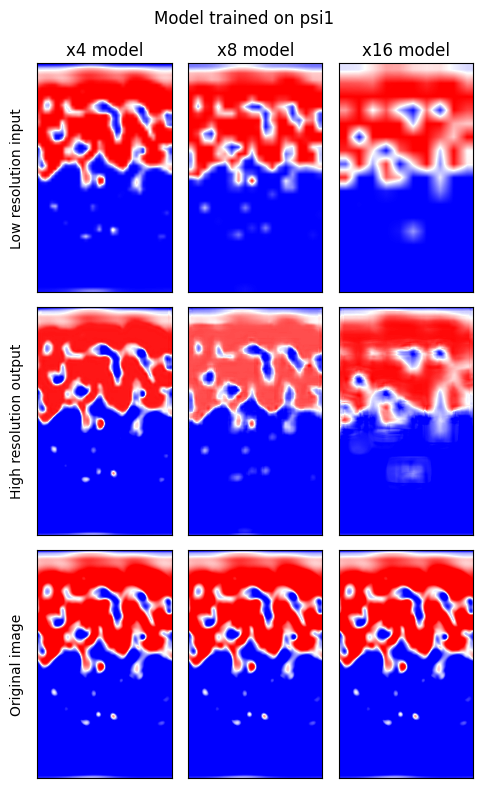

In [147]:
plot_results_psi("psi1")#, 568)

348

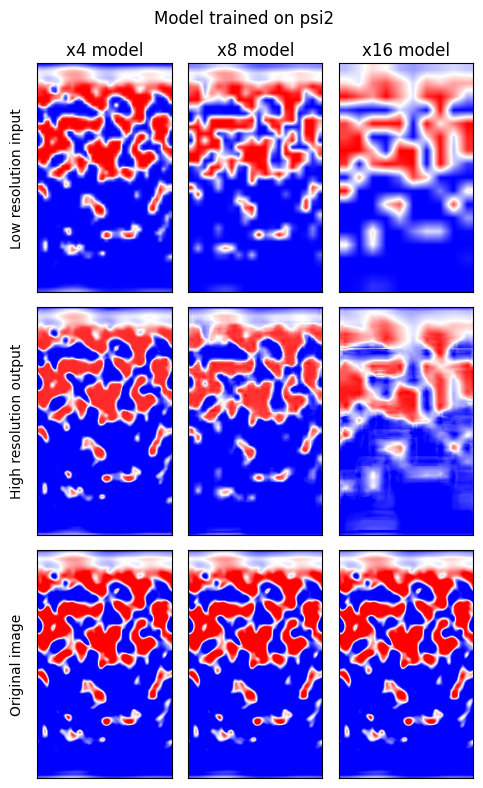

In [132]:
plot_results_psi("psi2", 348)